# Multi-prime modular addition grokking (NO normalization; prime observable)

This is the multi-prime NP/INP classification notebook im playing around with.
Each task is modular addition over a prime field:
$$c=(a+b)\bmod p.$$

## What’s observable vs knowledge
- **Observable task descriptor:** the prime \(p\) is provided explicitly as an input token.
- **Inputs:** \(x=(a,b,p)\) are **raw integers**.
- **INP knowledge:** \(\omega_p = 2\pi/p\) (circulant/Fourier frequency) is provided as a scalar and merged into the aggregated context representation via sum-merge.

## Model family (kept NP/INP-style)
A tiny deterministic Neural-Process-style classifier (CNP-style):
- context encoder maps \((x_i, y_i)\) to per-point reps \(r_i\)
- aggregate \(r = \text{mean}(r_i)\)
- decoder predicts logits for target \(x_j\) given \(r\)



In [1]:
import math
import time
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

def set_seed(seed: int = 0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)


device: cuda


## Task family: primes, per-prime train/test split over (a,b) pairs
We fix primes \(\le P_{max}\) so we can use a shared logit dimension `Pmax`.
For a task with prime \(p\), valid classes are \(0..p-1\); we mask logits \(\ge p\).


In [40]:
@dataclass
class PrimeTaskSpec:
    primes: List[int]
    train_frac: float = 0.4
    seed: int = 0

def build_tables_for_prime(p: int):
    a = np.repeat(np.arange(p), p)
    b = np.tile(np.arange(p), p)
    c = (a + b) % p
    X = np.stack([a, b], axis=1).astype(np.int64)  # [p^2,2]
    y = c.astype(np.int64)                         # [p^2]
    return X, y

def make_prime_splits(spec: PrimeTaskSpec):
    rng = np.random.default_rng(spec.seed)
    tables: Dict[int, Tuple[np.ndarray, np.ndarray]] = {}
    splits: Dict[int, Tuple[np.ndarray, np.ndarray]] = {}
    for p in spec.primes:
        X, y = build_tables_for_prime(p)
        idx = np.arange(len(X))
        rng.shuffle(idx)
        n_train = int(spec.train_frac * len(idx))
        tr_idx = idx[:n_train]
        te_idx = idx[n_train:]
        tables[p] = (X, y)
        splits[p] = (tr_idx, te_idx)
    Pmax = max(spec.primes)
    return tables, splits, Pmax

prime_spec = PrimeTaskSpec(primes=[101,113], train_frac=0.5, seed=0)
tables, splits, Pmax = make_prime_splits(prime_spec)

print("primes:", prime_spec.primes, "Pmax:", Pmax)
print("example split sizes:", {p: (len(splits[p][0]), len(splits[p][1])) for p in prime_spec.primes[:3]})


primes: [101, 113] Pmax: 113
example split sizes: {101: (5100, 5101), 113: (6384, 6385)}


## Batch sampler (raw integer tokens)
Each input point is:
$$x = (a, b, p) \in \mathbb{Z}^3.$$

We embed `a`, `b`, and `p` using separate embedding tables.


In [41]:
def sample_task_batch(
    primes: List[int],
    tables: Dict[int, Tuple[np.ndarray, np.ndarray]],
    splits: Dict[int, Tuple[np.ndarray, np.ndarray]],
    batch_tasks: int,
    n_ctx_max: int,
    n_tgt: int,
    split: str,
    seed: int,
):
    """Return a batch of tasks.

    Shapes:
      x_ctx: [B, Nc, 3] int64   (a,b,p)
      y_ctx: [B, Nc]    int64
      ctx_m: [B, Nc]    float mask
      x_tgt: [B, Nt, 3] int64
      y_tgt: [B, Nt]    int64
      p_t:   [B]        int64
      omega: [B, 1]     float32  (INP knowledge)
    """
    assert split in {"train", "test"}
    rng = np.random.default_rng(seed)

    p_t = rng.choice(primes, size=(batch_tasks,), replace=True)
    n_ctx = rng.integers(0, n_ctx_max + 1, size=(batch_tasks,))
    Nc = int(n_ctx.max()) if n_ctx.max() > 0 else 1

    x_ctx = np.zeros((batch_tasks, Nc, 3), dtype=np.int64)
    y_ctx = np.zeros((batch_tasks, Nc), dtype=np.int64)
    ctx_m = np.zeros((batch_tasks, Nc), dtype=np.float32)

    x_tgt = np.zeros((batch_tasks, n_tgt, 3), dtype=np.int64)
    y_tgt = np.zeros((batch_tasks, n_tgt), dtype=np.int64)

    omega = np.zeros((batch_tasks, 1), dtype=np.float32)

    for i in range(batch_tasks):
        p = int(p_t[i])
        X, y = tables[p]
        tr_idx, te_idx = splits[p]
        idx_pool = tr_idx if split == "train" else te_idx

        if n_ctx[i] > 0:
            c_idx = rng.choice(idx_pool, size=(int(n_ctx[i]),), replace=False if len(idx_pool) >= int(n_ctx[i]) else True)
            Xc = X[c_idx]  # [Nc_i,2]
            yc = y[c_idx]
            x_ctx[i, : int(n_ctx[i]), 0:2] = Xc
            x_ctx[i, : int(n_ctx[i]), 2] = p
            y_ctx[i, : int(n_ctx[i])] = yc
            ctx_m[i, : int(n_ctx[i])] = 1.0

        t_idx = rng.choice(idx_pool, size=(n_tgt,), replace=False if len(idx_pool) >= n_tgt else True)
        Xt = X[t_idx]
        yt = y[t_idx]
        x_tgt[i, :, 0:2] = Xt
        x_tgt[i, :, 2] = p
        y_tgt[i, :] = yt

        omega[i, 0] = 2.0 * np.pi / p

    return (
        torch.from_numpy(x_ctx).to(device),
        torch.from_numpy(y_ctx).to(device),
        torch.from_numpy(ctx_m).to(device),
        torch.from_numpy(x_tgt).to(device),
        torch.from_numpy(y_tgt).to(device),
        torch.from_numpy(p_t.astype(np.int64)).to(device),
        torch.from_numpy(omega).to(device),
    )


## NP-style model (deterministic CNP classifier) — token embeddings
We embed:
- `a` with `EmbA`
- `b` with `EmbB`
- `p` with `EmbP` (prime observable)

Then `x_vec = concat(EmbA(a), EmbB(b), EmbP(p))`.

Context encoder uses `x_vec` and an embedding of `y`.


In [42]:
def masked_mean(x: torch.Tensor, mask: torch.Tensor, dim: int = 1):
    m = mask.unsqueeze(-1)
    denom = m.sum(dim=dim).clamp_min(1.0)
    return (x * m).sum(dim=dim) / denom

class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden: int, out_dim: int, depth: int = 3):
        super().__init__()
        layers = []
        d = in_dim
        for _ in range(depth - 1):
            layers += [nn.Linear(d, hidden), nn.ReLU()]
            d = hidden
        layers += [nn.Linear(d, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class TinyCNPClassifierTokens(nn.Module):
    def __init__(self, Pmax: int, d_x: int = 64, y_emb: int = 64, r_dim: int = 128, hidden: int = 256):
        super().__init__()
        self.Pmax = Pmax
        # token embeddings for a,b,p (each ranges up to Pmax)
        self.emb_a = nn.Embedding(Pmax + 1, d_x)
        self.emb_b = nn.Embedding(Pmax + 1, d_x)
        self.emb_p = nn.Embedding(Pmax + 1, d_x)

        self.y_embed = nn.Embedding(Pmax, y_emb)

        x_vec_dim = 3 * d_x
        self.enc = MLP(x_vec_dim + y_emb, hidden, r_dim, depth=3)
        self.dec = MLP(x_vec_dim + r_dim, hidden, Pmax, depth=3)

    def x_embed(self, x_tokens: torch.Tensor):
        # x_tokens: [B,N,3] int64 = (a,b,p)
        a = x_tokens[..., 0].clamp(0, self.Pmax)
        b = x_tokens[..., 1].clamp(0, self.Pmax)
        p = x_tokens[..., 2].clamp(0, self.Pmax)
        ea = self.emb_a(a)
        eb = self.emb_b(b)
        ep = self.emb_p(p)
        return torch.cat([ea, eb, ep], dim=-1)  # [B,N,3*d_x]

    def encode(self, x_ctx, y_ctx, ctx_m):
        xvec = self.x_embed(x_ctx)  # [B,N,Dx]
        yemb = self.y_embed(y_ctx.clamp(min=0, max=self.Pmax - 1))
        h = torch.cat([xvec, yemb], dim=-1)
        r_i = self.enc(h)
        r = masked_mean(r_i, ctx_m, 1)
        return r

    def forward(self, x_ctx, y_ctx, ctx_m, x_tgt):
        r = self.encode(x_ctx, y_ctx, ctx_m)             # [B,r_dim]
        xvec_t = self.x_embed(x_tgt)                     # [B,Nt,Dx]
        B, Nt, _ = xvec_t.shape
        r_rep = r[:, None, :].expand(-1, Nt, -1)
        logits = self.dec(torch.cat([xvec_t, r_rep], dim=-1))  # [B,Nt,Pmax]
        return logits

class TinyINPClassifierTokens(TinyCNPClassifierTokens):
    def __init__(self, Pmax: int, d_x: int = 64, y_emb: int = 64, r_dim: int = 128, hidden: int = 256, k_dim: int = 128):
        super().__init__(Pmax=Pmax, d_x=d_x, y_emb=y_emb, r_dim=r_dim, hidden=hidden)
        self.k_enc = MLP(1, hidden, k_dim, depth=3)
        self.k_proj = nn.Linear(k_dim, r_dim)

    def forward(self, x_ctx, y_ctx, ctx_m, x_tgt, omega):
        r = self.encode(x_ctx, y_ctx, ctx_m)
        k = self.k_proj(self.k_enc(omega))
        r = r + k
        xvec_t = self.x_embed(x_tgt)
        B, Nt, _ = xvec_t.shape
        r_rep = r[:, None, :].expand(-1, Nt, -1)
        logits = self.dec(torch.cat([xvec_t, r_rep], dim=-1))
        return logits


## Masked cross-entropy for variable prime p

In [43]:
def mask_logits_for_prime(logits: torch.Tensor, p_t: torch.Tensor):
    # logits: [B,Nt,Pmax], p_t: [B]
    B, Nt, Pmax_ = logits.shape
    classes = torch.arange(Pmax_, device=logits.device)[None, None, :]  # [1,1,Pmax]
    p = p_t[:, None, None]                                             # [B,1,1]
    valid = classes < p
    return logits.masked_fill(~valid, -1e9)

def batch_loss_and_acc(logits: torch.Tensor, y_tgt: torch.Tensor, p_t: torch.Tensor):
    logits_m = mask_logits_for_prime(logits, p_t)
    loss = F.cross_entropy(logits_m.reshape(-1, logits_m.shape[-1]), y_tgt.reshape(-1))
    pred = logits_m.argmax(dim=-1)
    acc = (pred == y_tgt).float().mean()
    return loss, acc


## Training loop

In [44]:
@dataclass
class TrainSpec:
    steps: int = 80000
    batch_tasks: int = 64
    n_ctx_max: int = 32
    n_tgt: int = 64
    lr: float = 3e-3
    weight_decay: float = 5e-2
    eval_every: int = 800
    seed: int = 0

@torch.no_grad()
def eval_model(model, primes_eval, inp: bool, ts: TrainSpec, n_batches: int = 40, split: str = "test"):
    model.eval()
    accs, losses = [], []
    for i in range(n_batches):
        x_ctx, y_ctx, ctx_m, x_tgt, y_tgt, p_t, omega = sample_task_batch(
            primes=primes_eval, tables=tables, splits=splits,
            batch_tasks=ts.batch_tasks, n_ctx_max=ts.n_ctx_max, n_tgt=ts.n_tgt,
            split=split, seed=ts.seed + 100000 + i
        )
        logits = model(x_ctx, y_ctx, ctx_m, x_tgt, omega=omega) if inp else model(x_ctx, y_ctx, ctx_m, x_tgt)
        loss, acc = batch_loss_and_acc(logits, y_tgt, p_t)
        losses.append(loss.item())
        accs.append(acc.item())
    return float(np.mean(losses)), float(np.mean(accs))

def train(model, primes_train, primes_eval, inp: bool, ts: TrainSpec):
    set_seed(ts.seed)
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=ts.lr, weight_decay=ts.weight_decay)

    hist = {"step": [], "train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    t0 = time.time()

    for step in range(1, ts.steps + 1):
        model.train()
        x_ctx, y_ctx, ctx_m, x_tgt, y_tgt, p_t, omega = sample_task_batch(
            primes=primes_train, tables=tables, splits=splits,
            batch_tasks=ts.batch_tasks, n_ctx_max=ts.n_ctx_max, n_tgt=ts.n_tgt,
            split="train", seed=ts.seed + step
        )

        opt.zero_grad(set_to_none=True)
        logits = model(x_ctx, y_ctx, ctx_m, x_tgt, omega=omega) if inp else model(x_ctx, y_ctx, ctx_m, x_tgt)
        loss, acc = batch_loss_and_acc(logits, y_tgt, p_t)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        if step == 1 or step % ts.eval_every == 0:
            tr_loss, tr_acc = eval_model(model, primes_train, inp=inp, ts=ts, n_batches=30, split="train")
            te_loss, te_acc = eval_model(model, primes_eval,  inp=inp, ts=ts, n_batches=30, split="test")
            hist["step"].append(step)
            hist["train_loss"].append(tr_loss)
            hist["train_acc"].append(tr_acc)
            hist["test_loss"].append(te_loss)
            hist["test_acc"].append(te_acc)
            dt = time.time() - t0
            tag = "INP" if inp else "NP"
            print(f"[{tag} {step:6d}/{ts.steps}] train acc={tr_acc:.3f} test acc={te_acc:.3f} | "
                  f"train loss={tr_loss:.3f} test loss={te_loss:.3f} | {dt:.1f}s")

    return hist


## Run: NP-style vs INP (knowledge=omega)
Defaults are tuned to be more grokking-friendly (longer training, decent weight decay).
If NP still doesn’t show a delayed jump, bump `weight_decay` to 0.1–0.5 and `steps` to 200k.


In [45]:
primes_train = prime_spec.primes
primes_eval  = prime_spec.primes

ts = TrainSpec(
    steps=20000,
    batch_tasks=64,
    n_ctx_max=32,
    n_tgt=64,
    lr=3e-3,
    weight_decay=5e-2,
    eval_every=800,
    seed=0,
)

np_model  = TinyCNPClassifierTokens(Pmax=Pmax, d_x=64, y_emb=64, r_dim=128, hidden=256)
inp_model = TinyINPClassifierTokens(Pmax=Pmax, d_x=64, y_emb=64, r_dim=128, hidden=256, k_dim=128)

print("Training NP-style...")
hist_np = train(np_model, primes_train, primes_eval, inp=False, ts=ts)

print("\nTraining INP (omega knowledge)...")
ts_inp = TrainSpec(**{**ts.__dict__, "seed": 1})
hist_inp = train(inp_model, primes_train, primes_eval, inp=True, ts=ts_inp)


Training NP-style...
[NP      1/20000] train acc=0.012 test acc=0.008 | train loss=4.665 test loss=4.676 | 0.3s
[NP    800/20000] train acc=1.000 test acc=0.083 | train loss=0.009 test loss=12.713 | 6.7s
[NP   1600/20000] train acc=1.000 test acc=0.092 | train loss=0.004 test loss=12.676 | 13.1s
[NP   2400/20000] train acc=1.000 test acc=0.099 | train loss=0.002 test loss=12.458 | 19.7s
[NP   3200/20000] train acc=1.000 test acc=0.107 | train loss=0.001 test loss=12.225 | 26.3s
[NP   4000/20000] train acc=1.000 test acc=0.115 | train loss=0.001 test loss=11.990 | 32.9s
[NP   4800/20000] train acc=1.000 test acc=0.123 | train loss=0.001 test loss=11.747 | 39.5s
[NP   5600/20000] train acc=1.000 test acc=0.131 | train loss=0.000 test loss=11.506 | 45.9s
[NP   6400/20000] train acc=1.000 test acc=0.138 | train loss=0.000 test loss=11.242 | 52.4s
[NP   7200/20000] train acc=1.000 test acc=0.146 | train loss=0.000 test loss=10.959 | 58.9s
[NP   8000/20000] train acc=1.000 test acc=0.153 | t

## Plot grokking curves

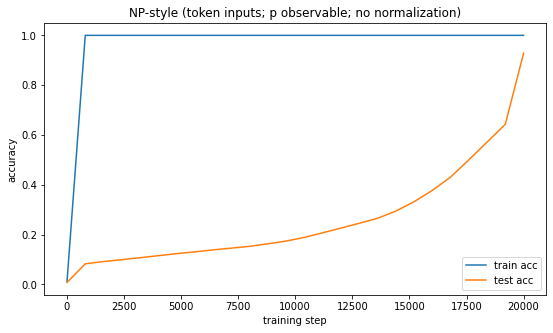

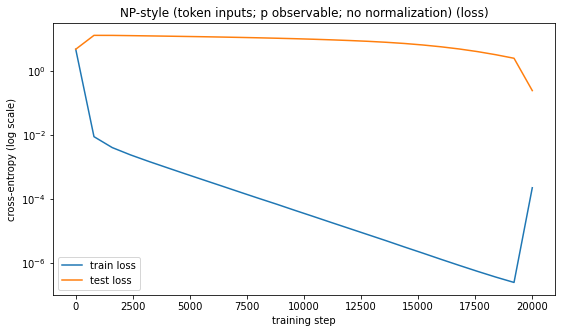

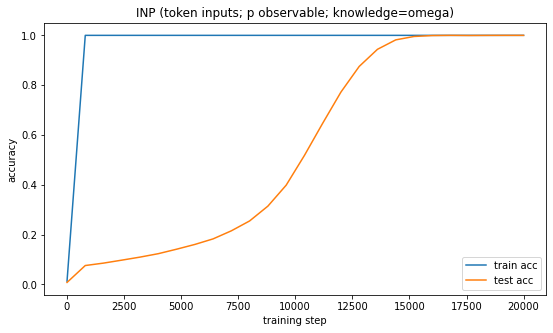

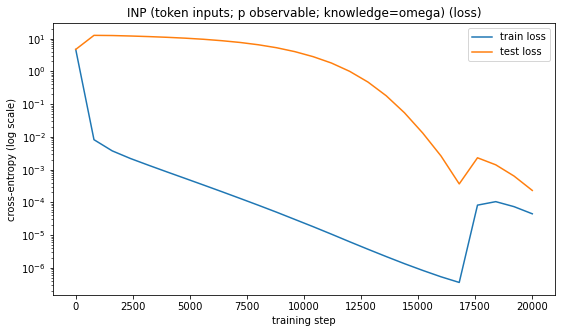

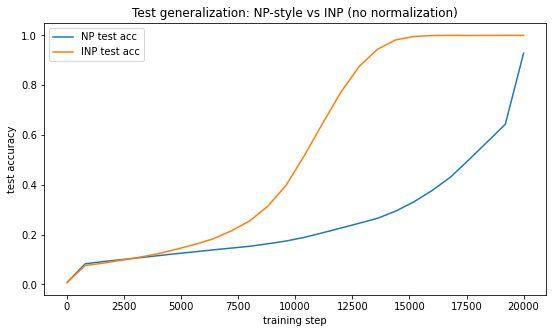

In [47]:
def plot_hist(h: Dict, title: str):
    steps = np.array(h["step"])
    plt.figure(figsize=(9,5))
    plt.plot(steps, h["train_acc"], label="train acc")
    plt.plot(steps, h["test_acc"],  label="test acc")
    plt.xlabel("training step")
    plt.ylabel("accuracy")
    plt.title(title)
    plt.legend()
    plt.show()

    plt.figure(figsize=(9,5))
    plt.plot(steps, h["train_loss"], label="train loss")
    plt.plot(steps, h["test_loss"],  label="test loss")
    plt.yscale("log")
    plt.xlabel("training step")
    plt.ylabel("cross-entropy (log scale)")
    plt.title(title + " (loss)")
    plt.legend()
    plt.show()

plot_hist(hist_np,  "NP-style (token inputs; p observable; no normalization)")
plot_hist(hist_inp, "INP (token inputs; p observable; knowledge=omega)")

plt.figure(figsize=(9,5))
plt.plot(hist_np["step"],  hist_np["test_acc"],  label="NP test acc")
plt.plot(hist_inp["step"], hist_inp["test_acc"], label="INP test acc")
plt.xlabel("training step")
plt.ylabel("test accuracy")
plt.title("Test generalization: NP-style vs INP (no normalization)")
plt.legend()
plt.show()


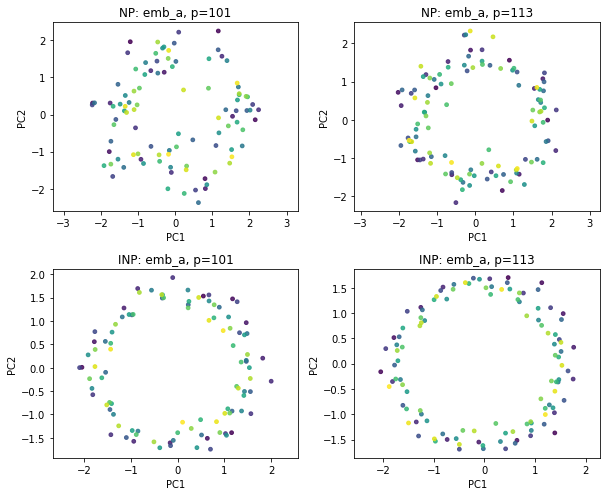

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def pca2(X: np.ndarray):
    Xc = X - X.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    return Xc @ Vt.T[:, :2]

def emb_pca(model, p, emb_attr="emb_a"):
    W = getattr(model, emb_attr).weight.detach().cpu().numpy()[:p]
    return pca2(W)

def scatter_pca(ax, Z, title):
    idx = np.arange(Z.shape[0])
    ax.scatter(Z[:, 0], Z[:, 1], c=idx, s=14, alpha=0.85)
    ax.set_title(title)
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
    ax.axis("equal")

primes = list(prime_spec.primes)          # all primes in your task set
emb_attr = "emb_a"                        # change to emb_b / emb_p if desired

fig, axes = plt.subplots(2, len(primes), figsize=(4.2 * len(primes), 7), squeeze=False)

for j, p in enumerate(primes):
    Z_np  = emb_pca(np_model,  p, emb_attr)
    Z_inp = emb_pca(inp_model, p, emb_attr)

    scatter_pca(axes[0, j], Z_np,  f"NP: {emb_attr}, p={p}")
    scatter_pca(axes[1, j], Z_inp, f"INP: {emb_attr}, p={p}")

axes[0, 0].set_ylabel("PC2")
axes[1, 0].set_ylabel("PC2")

plt.tight_layout()
plt.show()
